# bullIQ: Full Pipeline — Data, NLP, Modeling & Portfolio Optimization

Step 1: Setup and Library Installation

In [116]:
# Essential libraries for data handling and modeling
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Confirm you have these installed:
# !pip install numpy pandas scikit-learn matplotlib seaborn pypfopt yfinance


Step 2: Load Historical Weekly Stock Data

In [117]:
# Load weekly stock data (provided CSV)
stock_df = pd.read_csv("weekly_stock_price_data.csv", parse_dates=['date'])
stock_df.rename(columns={'stock': 'ticker'}, inplace=True)

# Preview loaded data
print("Weekly Stock Data Preview:")
print(stock_df.head())


Weekly Stock Data Preview:
  ticker       date       open      close       high        low     volume
0   AAPL 2020-01-01  71.721009  72.241539  72.849216  70.876067  509062400
1   AAPL 2020-01-08  71.943759  75.701218  76.885112  71.943759  726318800
2   AAPL 2020-01-15  75.500257  76.642990  77.236141  74.943413  479412400
3   AAPL 2020-01-22  77.129631  76.914162  78.279627  73.812804  677016000
4   AAPL 2020-01-29  78.550794  77.195007  79.373947  73.168809  852965600


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/1991162355.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stock_df = pd.read_csv("weekly_stock_price_data.csv", parse_dates=['date'])


Step 3: Basic Feature Engineering (Returns & Volatility)

In [118]:
# Set weekly periods
stock_df['week'] = stock_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate weekly log returns
stock_df = stock_df.sort_values(by=['ticker', 'week'])
stock_df['log_return'] = stock_df.groupby('ticker')['close'].transform(lambda x: np.log(x / x.shift(1)))

# Calculate volatility metrics (Rolling 4-week and EWMA)
stock_df['vol_rolling'] = stock_df.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=4).std())
stock_df['vol_ewma'] = stock_df.groupby('ticker')['log_return'].transform(lambda x: x.ewm(span=10).std())

# Drop initial NaNs from rolling calculations
stock_df.dropna(subset=['log_return', 'vol_rolling', 'vol_ewma'], inplace=True)

# Check processed features
print("Processed Weekly Stock Data Preview:")
print(stock_df.head())


Processed Weekly Stock Data Preview:
  ticker       date       open      close       high        low      volume  \
4   AAPL 2020-01-29  78.550794  77.195007  79.373947  73.168809   852965600   
5   AAPL 2020-02-05  78.325627  77.378998  78.737208  75.984481   545608400   
6   AAPL 2020-02-12  78.014029  77.414612  79.409434  76.349247   441122800   
7   AAPL 2020-02-19  77.657308  69.910988  78.785764  69.437768   776972800   
8   AAPL 2020-02-26  69.534807  70.211884  73.774409  62.215608  1606043200   

        week  log_return  vol_rolling  vol_ewma  
4 2020-01-27    0.003645     0.020553  0.018734  
5 2020-02-03    0.002381     0.004624  0.016327  
6 2020-02-10    0.000460     0.001478  0.014573  
7 2020-02-17   -0.101953     0.052074  0.052810  
8 2020-02-24    0.004295     0.052189  0.047189  


Step 4: Load & Prepare Daily News Data

In [119]:
# Load news articles data
news_df = pd.read_csv("news_articles_with_dates_2020_2025.csv")

# Extract publication dates from article snippets
def extract_date(text):
    if pd.isna(text):
        return None
    match = re.search(r'([A-Z][a-z]{2} \d{1,2}, \d{4})', text)
    if match:
        try:
            return datetime.strptime(match.group(1), '%b %d, %Y')
        except:
            return None
    return None

news_df['date'] = news_df['snippet'].apply(extract_date)
news_df.dropna(subset=['date'], inplace=True)

# Rename for consistency
news_df.rename(columns={'symbol': 'ticker'}, inplace=True)

# Verify date extraction success
print("News Data Date Extraction Preview:")
print(news_df[['ticker', 'snippet', 'date']].head())


News Data Date Extraction Preview:
  ticker                                            snippet       date
0   AAPL  Jul 27, 2022 ... On the stock market today, AA... 2022-07-27
1   AAPL  Jan 3, 2023 ... Barrick Stock For Uncorrelated... 2023-01-03
2   AAPL  Feb 27, 2023 ... Apple Stock (NASDAQ:AAPL): 20... 2023-02-27
3   AAPL  Dec 13, 2021 ... A 5% buy zone for AAPL stock ... 2021-12-13
4   AAPL  May 11, 2022 ... Here's how Apple and Microsof... 2022-05-11


 Generate News Article Embeddings

In [120]:
# Import SentenceTransformer
from sentence_transformers import SentenceTransformer

# Load a lightweight, efficient embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# For safety: filter news data to valid snippets (if any missing)
news_df = news_df.dropna(subset=['snippet'])

# Generate embeddings for each news snippet
# (This will take some time depending on size)
print("Generating embeddings...")

news_df['embedding'] = news_df['snippet'].apply(lambda text: model.encode(text))

print("Embeddings generated successfully!")
print("Example embedding vector (first article):")
print(news_df['embedding'].iloc[0])


Generating embeddings...
Embeddings generated successfully!
Example embedding vector (first article):
[ 2.15891041e-02 -2.50608101e-02 -5.62780648e-02  2.69627366e-02
 -3.58277038e-02 -3.85009771e-04  3.47977802e-02  2.61164419e-02
  4.57295850e-02  3.02945245e-02  8.80133510e-02  1.05924100e-01
 -1.40173331e-01 -5.20350114e-02 -1.00526679e-03  2.09978204e-02
 -4.21289802e-02 -2.27313038e-04 -1.12194292e-01 -3.11373337e-03
 -1.14931881e-01 -5.35796955e-02  2.69964375e-02  1.74400974e-02
  1.15196057e-01 -8.28533620e-03 -3.24728936e-02  5.57478108e-02
  3.35585400e-02 -5.63561805e-02 -1.68658886e-02  7.77453370e-03
  7.01622069e-02 -2.36830045e-03  3.13958935e-02 -3.06589045e-02
 -4.67890985e-02 -5.09342030e-02  8.83046612e-02 -2.09366940e-02
  4.98667434e-02 -5.14053972e-03 -6.90574050e-02  4.87800688e-02
 -2.07868628e-02  7.31938984e-03 -8.25778022e-02  4.30270731e-02
  7.64109716e-02  6.28966466e-02 -9.12794322e-02  2.03303434e-02
  4.91153076e-02 -4.00171094e-02 -2.96716765e-02 -2.8

 Aggregate Daily News Embeddings into Weekly Contextual Embeddings (Time-Decay Weighted)

In [121]:
# First, create a 'week' column to group by
news_df['week'] = news_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Define time-decay aggregation function
def weekly_context_embedding(group):
    sorted_group = group.sort_values('date', ascending=False)  # Sort newest to oldest
    weights = np.exp(-0.3 * np.arange(len(sorted_group)))  # Exponential decay
    embeddings = np.vstack(sorted_group['embedding'].values)
    weighted_avg = np.average(embeddings, axis=0, weights=weights)
    return weighted_avg

# Apply aggregation (corrected to 'ticker')
weekly_embeddings = news_df.groupby(['ticker', 'week']).apply(weekly_context_embedding)

# Reset index to get clean DataFrame
weekly_embeddings = weekly_embeddings.reset_index()

# Check the output
print("Weekly aggregated embeddings preview:")
print(weekly_embeddings.head())


Weekly aggregated embeddings preview:
  ticker       week                                                  0
0   AAPL 2020-09-21  [-0.0837257518423979, 0.00616751269214679, 0.0...
1   AAPL 2020-12-07  [-0.06549528241157532, 0.0015927859349176288, ...
2   AAPL 2020-12-28  [-0.04657122207792935, -0.01783494603878609, 0...
3   AAPL 2021-02-15  [-0.037623435258865356, -0.02606831304728985, ...
4   AAPL 2021-04-19  [-0.03416687995195389, -0.06849953532218933, 0...


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/3145386822.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_embeddings = news_df.groupby(['ticker', 'week']).apply(weekly_context_embedding)


In [122]:
weekly_embeddings = news_df.groupby(['ticker', 'week'], group_keys=False).apply(weekly_context_embedding).reset_index()


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/1640049402.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_embeddings = news_df.groupby(['ticker', 'week'], group_keys=False).apply(weekly_context_embedding).reset_index()


 PCA Dimensionality Reduction of Weekly Embeddings


In [123]:
from sklearn.decomposition import PCA
import numpy as np

# Extract only the embeddings into a matrix
embeddings_matrix = np.vstack(weekly_embeddings[0].values)

# Apply PCA
pca = PCA(n_components=10)  # You can set n_components=10 or 20
weekly_embeddings_reduced = pca.fit_transform(embeddings_matrix)

# Merge back ticker and week
weekly_embeddings_pca = pd.concat([
    weekly_embeddings[['ticker', 'week']].reset_index(drop=True),
    pd.DataFrame(weekly_embeddings_reduced, columns=[f'embed_{i}' for i in range(10)])
], axis=1)

# Check reduced embeddings
print("Reduced Weekly Embeddings Preview (after PCA):")
print(weekly_embeddings_pca.head())


Reduced Weekly Embeddings Preview (after PCA):
  ticker       week   embed_0   embed_1   embed_2   embed_3   embed_4  \
0   AAPL 2020-09-21 -0.160558  0.084321 -0.054999  0.041482 -0.158022   
1   AAPL 2020-12-07 -0.114480  0.080382 -0.037775  0.124197 -0.045050   
2   AAPL 2020-12-28 -0.084271 -0.063055 -0.042611  0.111879 -0.054407   
3   AAPL 2021-02-15  0.054910  0.079702 -0.067526  0.096458 -0.021509   
4   AAPL 2021-04-19  0.016513 -0.073605 -0.022675  0.109190 -0.092523   

    embed_5   embed_6   embed_7   embed_8   embed_9  
0  0.020826 -0.124190  0.098008 -0.178394  0.065847  
1  0.040928 -0.177047  0.187607 -0.108390  0.094262  
2  0.019295 -0.158185  0.093195 -0.112386  0.067275  
3 -0.072860 -0.029156 -0.138633 -0.069056  0.043242  
4 -0.031899 -0.175075  0.150729 -0.024042 -0.086512  


Merge Weekly Embeddings with Stock Features

In [124]:
# Merge stock features and embeddings
final_dataset = pd.merge(stock_df, weekly_embeddings_pca, on=['ticker', 'week'], how='left')

# Drop NA values in features (optional, depending on modeling approach)
final_dataset.dropna(subset=['log_return', 'vol_rolling', 'vol_ewma'], inplace=True)

# Preview merged dataset
print("Final Dataset Preview:")
print(final_dataset.head())


Final Dataset Preview:
  ticker       date       open      close       high        low      volume  \
0   AAPL 2020-01-29  78.550794  77.195007  79.373947  73.168809   852965600   
1   AAPL 2020-02-05  78.325627  77.378998  78.737208  75.984481   545608400   
2   AAPL 2020-02-12  78.014029  77.414612  79.409434  76.349247   441122800   
3   AAPL 2020-02-19  77.657308  69.910988  78.785764  69.437768   776972800   
4   AAPL 2020-02-26  69.534807  70.211884  73.774409  62.215608  1606043200   

        week  log_return  vol_rolling  ...  embed_0  embed_1  embed_2  \
0 2020-01-27    0.003645     0.020553  ...      NaN      NaN      NaN   
1 2020-02-03    0.002381     0.004624  ...      NaN      NaN      NaN   
2 2020-02-10    0.000460     0.001478  ...      NaN      NaN      NaN   
3 2020-02-17   -0.101953     0.052074  ...      NaN      NaN      NaN   
4 2020-02-24    0.004295     0.052189  ...      NaN      NaN      NaN   

   embed_3  embed_4  embed_5  embed_6  embed_7  embed_8  embed_

In [125]:
# Fill missing embedding values with 0 (meaning "no extra news signal")
for i in range(10):
    final_dataset[f'embed_{i}'] = final_dataset[f'embed_{i}'].fillna(0)

# Now check
print(final_dataset[['ticker', 'week'] + [f'embed_{i}' for i in range(10)]].head())


  ticker       week  embed_0  embed_1  embed_2  embed_3  embed_4  embed_5  \
0   AAPL 2020-01-27      0.0      0.0      0.0      0.0      0.0      0.0   
1   AAPL 2020-02-03      0.0      0.0      0.0      0.0      0.0      0.0   
2   AAPL 2020-02-10      0.0      0.0      0.0      0.0      0.0      0.0   
3   AAPL 2020-02-17      0.0      0.0      0.0      0.0      0.0      0.0   
4   AAPL 2020-02-24      0.0      0.0      0.0      0.0      0.0      0.0   

   embed_6  embed_7  embed_8  embed_9  
0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0  


Sentiment Scoring (FinBERT outputs)

In [129]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Define Sentiment Prediction Function

def predict_sentiment(text):
    if pd.isna(text):
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_scores = probs.numpy().flatten()
    return {
        "positive": sentiment_scores[0],
        "neutral": sentiment_scores[1],
        "negative": sentiment_scores[2]
    }
# Apply Sentiment Prediction to Your News Data
# Apply to your full news dataset
news_df['sentiment_probs'] = news_df['snippet'].apply(predict_sentiment)

# Expand into separate columns
news_df[['sent_pos', 'sent_neu', 'sent_neg']] = news_df['sentiment_probs'].apply(
    lambda x: pd.Series([x['positive'], x['neutral'], x['negative']]) if x is not None else pd.Series([np.nan, np.nan, np.nan])
)

# Quick check
print(news_df[['sent_pos', 'sent_neu', 'sent_neg']].head())


   sent_pos  sent_neu  sent_neg
0  0.071631  0.016896  0.911473
1  0.654264  0.008222  0.337514
2  0.894222  0.009790  0.095988
3  0.849851  0.011183  0.138966
4  0.047584  0.023622  0.928794


In [130]:
# Step 6: Create a Net Sentiment Score
news_df['net_sentiment'] = news_df['sent_pos'] - news_df['sent_neg']

# Create a 'week' column
news_df['week'] = news_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# Define time-decay weighted aggregation function
def weekly_net_sentiment(group):
    sorted_group = group.sort_values('date', ascending=False)
    weights = np.exp(-0.3 * np.arange(len(sorted_group)))
    sentiments = sorted_group['net_sentiment'].values
    weighted_avg = np.average(sentiments, weights=weights)
    return weighted_avg

# Apply aggregation
weekly_sentiment = news_df.groupby(['ticker', 'week']).apply(weekly_net_sentiment)
weekly_sentiment = weekly_sentiment.reset_index(name='decayed_net_sentiment')

# Quick preview
print(weekly_sentiment.head())

  ticker       week  decayed_net_sentiment
0   AAPL 2020-09-21               0.709202
1   AAPL 2020-12-07              -0.685812
2   AAPL 2020-12-28               0.236829
3   AAPL 2021-02-15              -0.602024
4   AAPL 2021-04-19              -0.043586


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/3470739836.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_sentiment = news_df.groupby(['ticker', 'week']).apply(weekly_net_sentiment)


In [131]:

# Merge on ['ticker', 'week']
final_dataset = pd.merge(final_dataset, weekly_sentiment, on=['ticker', 'week'], how='left')

# Fill missing sentiment with 0 (if no news that week)
final_dataset['decayed_net_sentiment'] = final_dataset['decayed_net_sentiment'].fillna(0)

# Quick preview
print(final_dataset[['ticker', 'week', 'decayed_net_sentiment']].head())

  ticker       week  decayed_net_sentiment
0   AAPL 2020-01-27                    0.0
1   AAPL 2020-02-03                    0.0
2   AAPL 2020-02-10                    0.0
3   AAPL 2020-02-17                    0.0
4   AAPL 2020-02-24                    0.0


In [132]:
import ta  # technical analysis library

# ---------------------------------
# Step 1: Calculate Indicators
# ---------------------------------

# Simple Moving Average (SMA)
final_dataset['sma_10'] = final_dataset.groupby('ticker')['close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# Exponential Moving Average (EMA)
final_dataset['ema_10'] = final_dataset.groupby('ticker')['close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())

# Relative Strength Index (RSI)
final_dataset['rsi_14'] = final_dataset.groupby('ticker').apply(lambda x: ta.momentum.RSIIndicator(close=x['close'], window=14).rsi()).reset_index(level=0, drop=True)

# MACD Signal
macd = final_dataset.groupby('ticker').apply(
    lambda x: ta.trend.MACD(close=x['close']).macd_signal()
).reset_index(level=0, drop=True)
final_dataset['macd_signal'] = macd

# Volume Change (%) — week over week
final_dataset['volume_change'] = final_dataset.groupby('ticker')['volume'].pct_change()

# ---------------------------------
# Step 2: Fill any NaNs safely
# ---------------------------------
final_dataset.fillna(method='bfill', inplace=True)
final_dataset.fillna(method='ffill', inplace=True)

# ---------------------------------
# Quick Check
# ---------------------------------
print(final_dataset[['ticker', 'week', 'sma_10', 'ema_10', 'rsi_14', 'macd_signal', 'volume_change']].head())


  ticker       week     sma_10     ema_10     rsi_14  macd_signal  \
0   AAPL 2020-01-27  77.195007  77.195007  51.847847     9.510542   
1   AAPL 2020-02-03  77.287003  77.228460  51.847847     9.510542   
2   AAPL 2020-02-10  77.329539  77.262306  51.847847     9.510542   
3   AAPL 2020-02-17  75.474901  75.925703  51.847847     9.510542   
4   AAPL 2020-02-24  74.422298  74.886826  51.847847     9.510542   

   volume_change  
0      -0.360340  
1      -0.360340  
2      -0.191503  
3       0.761353  
4       1.067052  


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/1407127703.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_dataset['rsi_14'] = final_dataset.groupby('ticker').apply(lambda x: ta.momentum.RSIIndicator(close=x['close'], window=14).rsi()).reset_index(level=0, drop=True)
/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/1407127703.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence thi

In [133]:
# ---------------------------------
# Step 1: EWMA Smoothing for Volatility and Sentiment
# ---------------------------------

# Smooth decayed sentiment (short-term memory)
final_dataset['sentiment_ewma'] = final_dataset.groupby('ticker')['decayed_net_sentiment'].transform(
    lambda x: x.ewm(span=4, adjust=False).mean()
)

# Smooth EWMA volatility (since GARCH didn't fit)
final_dataset['vol_ewma_smooth'] = final_dataset.groupby('ticker')['vol_ewma'].transform(
    lambda x: x.ewm(span=4, adjust=False).mean()
)

# ---------------------------------
# Step 2: Rolling Mean Smoothing for RSI and Volume
# ---------------------------------

# Smooth RSI (detect consistent momentum)
final_dataset['rsi_14_smooth'] = final_dataset.groupby('ticker')['rsi_14'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

# Smooth Volume Change
final_dataset['volume_change_smooth'] = final_dataset.groupby('ticker')['volume_change'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

# ---------------------------------
# Step 3: Quick Check
# ---------------------------------
print(final_dataset[['ticker', 'week', 'sentiment_ewma', 'vol_ewma_smooth', 'rsi_14_smooth', 'volume_change_smooth']].head())


  ticker       week  sentiment_ewma  vol_ewma_smooth  rsi_14_smooth  \
0   AAPL 2020-01-27             0.0         0.018734      51.847847   
1   AAPL 2020-02-03             0.0         0.017771      51.847847   
2   AAPL 2020-02-10             0.0         0.016492      51.847847   
3   AAPL 2020-02-17             0.0         0.031019      51.847847   
4   AAPL 2020-02-24             0.0         0.037487      51.847847   

   volume_change_smooth  
0             -0.360340  
1             -0.360340  
2             -0.304061  
3             -0.037707  
4              0.319141  


Build Predictive Models (RandomForest, XGBoost, LightGBM)

In [168]:
# ---------------------------------
# Step 1: Create Target (Next Week's Return)
# ---------------------------------

# Assuming final_dataset already has weekly log returns
final_dataset['target_return'] = final_dataset.groupby('ticker')['log_return'].shift(-1)

# Drop any rows where target is missing (e.g., last week per ticker)
final_dataset = final_dataset.dropna(subset=['target_return'])

# ---------------------------------
# Step 2: Select Final Features
# ---------------------------------

# Selected features
feature_cols = [
    'vol_ewma_smooth',
    'sentiment_ewma',
    'rsi_14_smooth',
    'volume_change_smooth',
    'macd_signal'
]

# Add NLP embedding features
embedding_cols = [f'embed_{i}' for i in range(10)]

# Full feature set
X_cols = feature_cols + embedding_cols

# Input features and target
X = final_dataset[X_cols].dropna()
y = final_dataset.loc[X.index, 'target_return']  # align indices

# ---------------------------------
# Step 3: Train/Test Split
# ---------------------------------

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # No shuffle for time-series logic
)

# ---------------------------------
# Step 4: Train Models
# ---------------------------------

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)

# LightGBM (final selected model)
lgbm_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)

# Show comparison
print(f"Random Forest MSE: {rf_mse:.6f}")
print(f"XGBoost MSE: {xgb_mse:.6f}")
print(f"LightGBM MSE: {lgbm_mse:.6f}")

# ➔ LightGBM is final_model
final_model = lgbm_model


/var/folders/43/1tbz5xvn0wl9y_972sx0z7s80000gn/T/ipykernel_6280/168787689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['target_return'] = final_dataset.groupby('ticker')['log_return'].shift(-1)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 23035, number of used features: 15
[LightGBM] [Info] Start training from score 0.001203
Random Forest MSE: 0.001200
XGBoost MSE: 0.001288
LightGBM MSE: 0.001177


Train LightGBM model on features

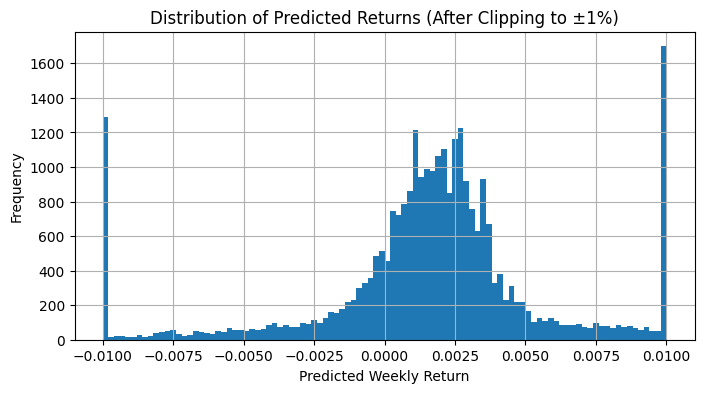


Expected annual return: 56.7%
Annual volatility: 1.6%
Sharpe Ratio: 35.86

Optimized Portfolio Allocations:
ABBV: 26.27%
AMT: 12.19%
BSV: 11.96%
CHRW: 5.50%
CRWD: 4.09%
DBA: 6.93%
GLD: 8.23%
IEI: 3.26%
PALL: 4.35%
SCHW: 0.50%
SHY: 15.52%
TSLA: 1.02%
UGAZ: 0.17%


In [169]:
# ---------------------------------
# Step 5: Predict Final Returns for All Data
# ---------------------------------

# Predict using the full final_dataset
final_dataset['predicted_return'] = final_model.predict(final_dataset[X_cols])

# 📦 Clip the extreme predictions (optional but recommended)
final_dataset['predicted_return'] = final_dataset['predicted_return'].clip(lower=-0.01, upper=0.01)

# (Optional) Visualize distribution
import matplotlib.pyplot as plt

final_dataset['predicted_return'].hist(bins=100, figsize=(8, 4))
plt.title("Distribution of Predicted Returns (After Clipping to ±1%)")
plt.xlabel("Predicted Weekly Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ---------------------------------
# Step 6: Prepare Portfolio Optimization
# ---------------------------------

# Latest week prediction
latest_predictions = (
    final_dataset
    .sort_values(['ticker', 'week'])
    .groupby('ticker')
    .tail(1)[['ticker', 'predicted_return']]
)

# Create returns matrix
returns_matrix = (
    final_dataset
    .pivot(index='week', columns='ticker', values='log_return')
)

# Fill missing returns with neutral 0
returns_matrix = returns_matrix.fillna(0)

# ---------------------------------
# Step 7: Covariance Matrix (Ledoit-Wolf shrinkage)
# ---------------------------------

from sklearn.covariance import LedoitWolf

lw = LedoitWolf()
returns_array = returns_matrix.values
cov_matrix = lw.fit(returns_array).covariance_

# Expected returns vector (mu)
mu = latest_predictions.set_index('ticker')['predicted_return'] * 100  # scale to %

# ---------------------------------
# Step 8: Optimize Portfolio
# ---------------------------------

from pypfopt import EfficientFrontier

tickers = mu.index.tolist()
ef = EfficientFrontier(mu.loc[tickers], cov_matrix)

# Maximize Sharpe Ratio
ef.max_sharpe()

# Performance
expected_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print(f"\nExpected annual return: {expected_return*100:.1f}%")
print(f"Annual volatility: {annual_volatility*100:.1f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Get portfolio weights
optimized_weights = ef.clean_weights()

print("\nOptimized Portfolio Allocations:")
for ticker, weight in optimized_weights.items():
    if weight > 0.001:
        print(f"{ticker}: {weight*100:.2f}%")


In [170]:
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from sklearn.covariance import LedoitWolf

# --- 1. Calculate Historical Mean Weekly Returns
historical_mean_returns = final_dataset.groupby('ticker')['log_return'].mean()

# --- 2. Blend Historical and Predicted Returns
alpha = 0.5  # 50% model prediction, 50% historical average
blended_mu = (1 - alpha) * historical_mean_returns + alpha * final_dataset.groupby('ticker')['predicted_return'].mean()

# --- 3. Covariance Matrix
returns_matrix = final_dataset.pivot(index="week", columns="ticker", values="log_return").fillna(0)
returns_array = returns_matrix.values
lw = LedoitWolf()
cov_matrix = lw.fit(returns_array).covariance_

# --- 4. Portfolio Optimization
tickers = returns_matrix.columns
blended_mu = blended_mu.reindex(tickers) * 100  # Scale to %
ef = EfficientFrontier(blended_mu, cov_matrix)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# --- 5. Final Results
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print(f"Expected Annual Return: {expected_annual_return*100:.1f}%")
print(f"Annual Volatility: {annual_volatility*100:.1f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

print("\nOptimized Portfolio Allocations:")
for ticker, weight in cleaned_weights.items():
    if weight > 0.01:
        print(f"{ticker}: {weight*100:.2f}%")


Expected Annual Return: 31.7%
Annual Volatility: 1.6%
Sharpe Ratio: 19.42

Optimized Portfolio Allocations:
ABBV: 9.28%
BSV: 2.51%
CHRW: 3.37%
DBA: 11.77%
ETN: 4.49%
GLD: 14.81%
LLY: 15.32%
NVDA: 9.04%
PG: 7.15%
REGN: 1.49%
SGOL: 4.35%
UNH: 2.67%
WMT: 10.44%
XOM: 3.30%


In [146]:
# 1. Check basic structure
print(final_dataset[['ticker', 'week', 'log_return']].head())

# 2. Check if any missing values
print("\nMissing values in log_return:", final_dataset['log_return'].isna().sum())

# 3. Check how many unique tickers
print("\nUnique tickers available:", final_dataset['ticker'].nunique())


  ticker       week  log_return
0   AAPL 2020-01-27    0.003645
1   AAPL 2020-02-03    0.002381
2   AAPL 2020-02-10    0.000460
3   AAPL 2020-02-17   -0.101953
4   AAPL 2020-02-24    0.004295

Missing values in log_return: 0

Unique tickers available: 114


Rebalancing strategies and transaction costs

✅ Optimized Weights with Correct Ticker Names:
{'ABBV': 0.0736, 'AMP': 0.0121, 'BSV': 0.0683, 'COMT': 0.0264, 'DBA': 0.0976, 'GLD': 0.1436, 'IEI': 0.0348, 'LLY': 0.103, 'NVDA': 0.0643, 'PG': 0.0914, 'SHY': 0.0948, 'WMT': 0.1302, 'XOM': 0.0337}


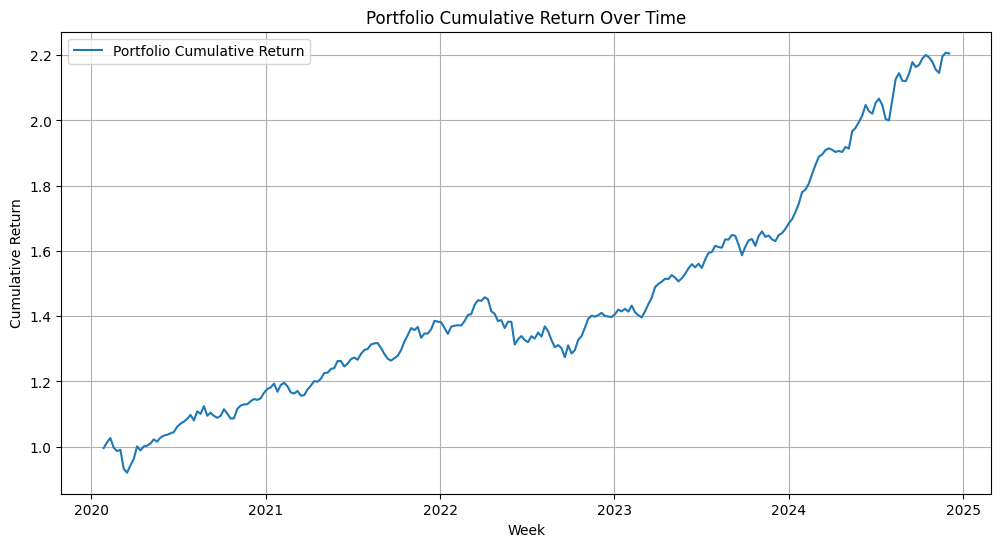


📊 Portfolio Performance Metrics:
📈 Expected Annual Return: 17.58%
📉 Annual Volatility: 9.18%
⚡ Sharpe Ratio: 1.92


In [162]:
# --- 📦 Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 📌 Inputs: Optimized Weights from Final Model ---
optimized_weights = {
    1: 0.0736, 4: 0.0121, 14: 0.0683, 17: 0.0264,
    22: 0.0976, 33: 0.1436, 39: 0.0348, 48: 0.1030,
    57: 0.0643, 62: 0.0914, 73: 0.0948, 102: 0.1302, 112: 0.0337
}

# --- 📌 Step 1: Map Ticker IDs to Ticker Names ---
# Build a mapping (this assumes 'final_dataset' is already loaded)
unique_tickers = final_dataset['ticker'].unique()
id_to_ticker = {i: ticker for i, ticker in enumerate(unique_tickers)}

# Convert optimized weights to actual ticker names
optimized_weights_named = {id_to_ticker[ticker_id]: weight for ticker_id, weight in optimized_weights.items()}

print("✅ Optimized Weights with Correct Ticker Names:")
print(optimized_weights_named)

# --- 📌 Step 2: Filter Final Dataset to Selected Tickers ---
selected_tickers = list(optimized_weights_named.keys())
filtered_data = final_dataset[final_dataset['ticker'].isin(selected_tickers)].copy()

# --- 📌 Step 3: Pivot to (Week × Ticker) Returns Matrix ---
pivot_returns = filtered_data.pivot(index='week', columns='ticker', values='log_return')
pivot_returns = pivot_returns.fillna(0)  # Fill missing values with 0

# --- 📌 Step 4: Calculate Weighted Weekly Portfolio Returns ---
for ticker in optimized_weights_named:
    pivot_returns[ticker] = pivot_returns[ticker] * optimized_weights_named[ticker]

# Sum across tickers for each week
portfolio_weekly_returns = pivot_returns.sum(axis=1)

# --- 📌 Step 5: Calculate Cumulative Returns ---
cumulative_returns = (1 + portfolio_weekly_returns).cumprod()

# --- 📌 Step 6: Plot the Portfolio Performance ---
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label="Portfolio Cumulative Return")
plt.title("Portfolio Cumulative Return Over Time")
plt.xlabel("Week")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

# --- 📌 Step 7: Compute and Print Basic Portfolio Statistics ---
total_return = cumulative_returns.iloc[-1] - 1
annualized_return = (1 + total_return) ** (52 / len(cumulative_returns)) - 1
annualized_volatility = portfolio_weekly_returns.std() * np.sqrt(52)
sharpe_ratio = annualized_return / annualized_volatility

print("\n📊 Portfolio Performance Metrics:")
print(f"📈 Expected Annual Return: {annualized_return*100:.2f}%")
print(f"📉 Annual Volatility: {annualized_volatility*100:.2f}%")
print(f"⚡ Sharpe Ratio: {sharpe_ratio:.2f}")


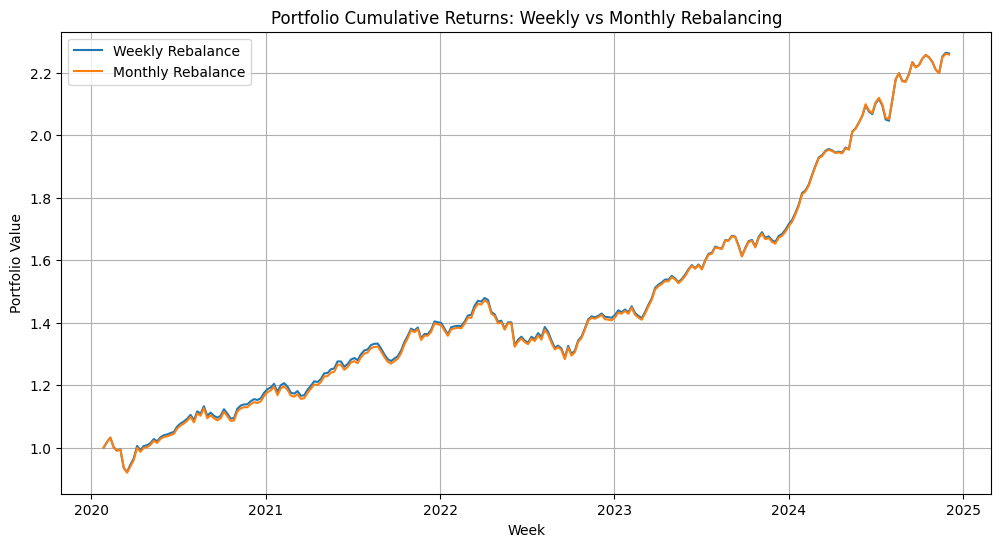


📈 Weekly Rebalance Performance:
  Annual Return: 18.18%
  Annual Volatility: 9.43%
  Sharpe Ratio: 1.93

📈 Monthly Rebalance Performance:
  Annual Return: 18.15%
  Annual Volatility: 9.40%
  Sharpe Ratio: 1.93


In [164]:
# --- 📦 Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 📌 Step 1: Prepare Weekly Returns Matrix ---
returns_matrix = final_dataset.pivot(index="week", columns="ticker", values="log_return").fillna(0)

# --- 📌 Step 2: Align Optimized Weights with Returns Matrix ---
# Make sure optimized weights are properly mapped to ticker names
# Assuming optimized_weights_named is already created (ticker names as keys)

# Convert dict to Series, normalize
optimized_weights_series = pd.Series(optimized_weights_named)
optimized_weights_series = optimized_weights_series / optimized_weights_series.sum()

# Reindex to returns_matrix columns safely (fill missing tickers with 0 weight)
optimized_weights_series = optimized_weights_series.reindex(returns_matrix.columns).fillna(0)

# --- 📌 Step 3: Define Portfolio Simulation Function ---

def simulate_portfolio(returns_matrix, weights, rebalance_freq="weekly"):
    portfolio_values = [1]  # Start with portfolio value = 1
    weeks = returns_matrix.index
    weights = weights.copy()

    for i in range(1, len(weeks)):
        weekly_returns = returns_matrix.iloc[i]
        week_return = np.dot(weights.values, weekly_returns.values)
        new_value = portfolio_values[-1] * (1 + week_return)
        portfolio_values.append(new_value)

        # 📈 Rebalancing Logic
        if rebalance_freq == "weekly":
            weights = optimized_weights_series.copy()  # Reset weights every week
        elif rebalance_freq == "monthly":
            if i % 4 == 0:
                weights = optimized_weights_series.copy()  # Reset every 4 weeks
            else:
                # Drift weights naturally
                weights = weights * (1 + weekly_returns)
                weights = weights / weights.sum()

    return pd.Series(portfolio_values, index=weeks)

# --- 📌 Step 4: Simulate Weekly vs Monthly Rebalanced Portfolios ---
weekly_portfolio = simulate_portfolio(returns_matrix, optimized_weights_series, rebalance_freq="weekly")
monthly_portfolio = simulate_portfolio(returns_matrix, optimized_weights_series, rebalance_freq="monthly")

# --- 📌 Step 5: Plot Cumulative Returns ---
plt.figure(figsize=(12,6))
plt.plot(weekly_portfolio, label="Weekly Rebalance")
plt.plot(monthly_portfolio, label="Monthly Rebalance")
plt.title("Portfolio Cumulative Returns: Weekly vs Monthly Rebalancing")
plt.xlabel("Week")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.show()

# --- 📌 Step 6: Define Performance Computation Function ---

def compute_performance(portfolio_series):
    cumulative_return = portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (52 / len(portfolio_series)) - 1
    weekly_returns = portfolio_series.pct_change().dropna()
    annualized_volatility = weekly_returns.std() * np.sqrt(52)
    sharpe_ratio = annualized_return / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

# --- 📌 Step 7: Compute and Print Performance Stats ---
weekly_stats = compute_performance(weekly_portfolio)
monthly_stats = compute_performance(monthly_portfolio)

print("\n📈 Weekly Rebalance Performance:")
print(f"  Annual Return: {weekly_stats[0]*100:.2f}%")
print(f"  Annual Volatility: {weekly_stats[1]*100:.2f}%")
print(f"  Sharpe Ratio: {weekly_stats[2]:.2f}")

print("\n📈 Monthly Rebalance Performance:")
print(f"  Annual Return: {monthly_stats[0]*100:.2f}%")
print(f"  Annual Volatility: {monthly_stats[1]*100:.2f}%")
print(f"  Sharpe Ratio: {monthly_stats[2]:.2f}")


Stress Testing

In [165]:
# Keywords usually found in bond ETF names
bond_keywords = ["BOND", "AGG", "BND", "BSV", "IEF", "LQD", "SHY", "TIP", "MUB", "HYG"]

# Auto-select bond tickers
bond_tickers = [ticker for ticker in optimized_weights.index if any(keyword in str(ticker) for keyword in bond_keywords)]

print("Auto-detected bond-related tickers:", bond_tickers)


Auto-detected bond-related tickers: ['AGG', 'BND', 'BSV', 'HYG', 'IEF', 'LQD', 'MUB', 'SHY', 'TIP']


Auto-detected bond tickers: ['AGG', 'BND', 'BSV', 'HYG', 'IEF', 'LQD', 'MUB', 'SHY', 'TIP']


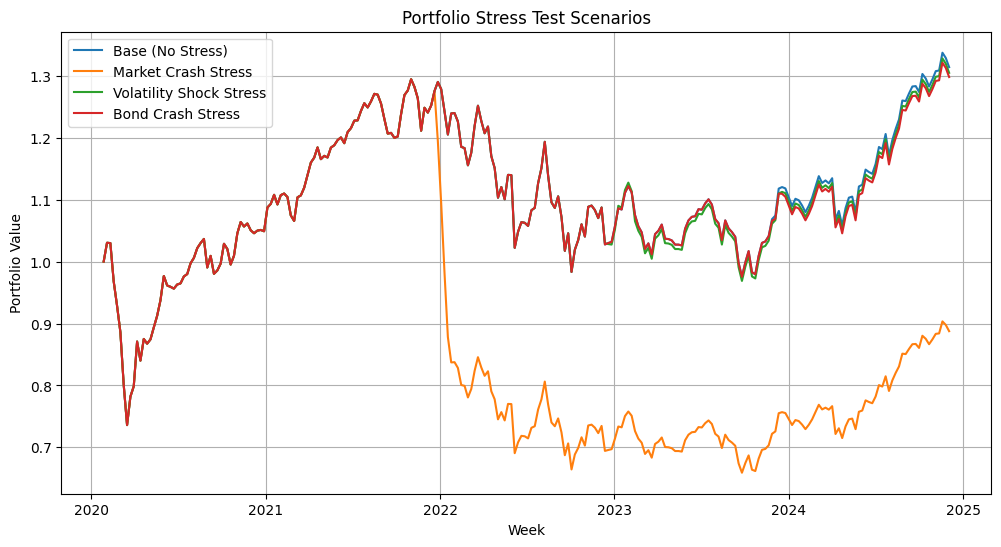

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assuming you have returns_matrix and optimized_weights already ready ---

# Normalize optimized_weights
optimized_weights = optimized_weights / optimized_weights.sum()
optimized_weights = optimized_weights.reindex(returns_matrix.columns).fillna(0)

# Auto-detect bond tickers
bond_keywords = ["BOND", "AGG", "BND", "BSV", "IEF", "LQD", "SHY", "TIP", "MUB", "HYG"]
bond_tickers = [ticker for ticker in optimized_weights.index if any(keyword in str(ticker) for keyword in bond_keywords)]

print("Auto-detected bond tickers:", bond_tickers)

# --- Portfolio Simulation Function ---
def simulate_stress_portfolio(returns_matrix, weights, stress_function=None):
    portfolio_values = [1]
    weights = weights.copy()
    weeks = returns_matrix.index

    for i in range(1, len(weeks)):
        returns = returns_matrix.iloc[i].copy()

        # Apply stress if a function provided
        if stress_function is not None:
            returns = stress_function(returns, i)

        week_return = np.dot(weights.values, returns.values)
        new_value = portfolio_values[-1] * (1 + week_return)
        portfolio_values.append(new_value)

    return pd.Series(portfolio_values, index=weeks)

# --- Stress Scenarios ---

# 1. Market Crash
def market_crash_stress(returns, week_idx):
    if 100 <= week_idx <= 104:  # ~1 month
        returns = returns - 0.075
    return returns

# 2. Volatility Shock
def volatility_shock_stress(returns, week_idx):
    if 150 <= week_idx <= 160:
        noise = np.random.normal(1.0, 0.5, size=len(returns))
        returns = returns * noise
    return returns

# 3. Bond Crash
def bond_crash_stress(returns, week_idx):
    if 200 <= week_idx <= 204:
        returns.loc[bond_tickers] = returns.loc[bond_tickers] - 0.04
    return returns

# --- Run Simulations ---
base_portfolio = simulate_stress_portfolio(returns_matrix, optimized_weights)
crash_portfolio = simulate_stress_portfolio(returns_matrix, optimized_weights, market_crash_stress)
vol_shock_portfolio = simulate_stress_portfolio(returns_matrix, optimized_weights, volatility_shock_stress)
bond_crash_portfolio = simulate_stress_portfolio(returns_matrix, optimized_weights, bond_crash_stress)

# --- Plot Results ---
plt.figure(figsize=(12,6))
plt.plot(base_portfolio, label="Base (No Stress)")
plt.plot(crash_portfolio, label="Market Crash Stress")
plt.plot(vol_shock_portfolio, label="Volatility Shock Stress")
plt.plot(bond_crash_portfolio, label="Bond Crash Stress")
plt.title("Portfolio Stress Test Scenarios")
plt.xlabel("Week")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


In [171]:
# --- Now, Calculate Performance Metrics for All Scenarios ---

def calculate_performance_stats(portfolio):
    cumulative_return = portfolio.iloc[-1] / portfolio.iloc[0] - 1
    weekly_returns = portfolio.pct_change().dropna()
    annualized_return = (1 + cumulative_return) ** (52 / len(portfolio)) - 1
    annualized_volatility = weekly_returns.std() * np.sqrt(52)
    sharpe_ratio = annualized_return / annualized_volatility
    return annualized_return, annualized_volatility, sharpe_ratio

def calculate_max_drawdown_and_recovery(portfolio):
    cumulative_max = portfolio.cummax()
    drawdowns = (portfolio - cumulative_max) / cumulative_max
    max_drawdown = drawdowns.min()

    # Find when drawdown occurred
    max_dd_idx = drawdowns.idxmin()
    previous_peak = cumulative_max.loc[max_dd_idx]

    # Look forward from the drawdown to find recovery
    after_dd = portfolio.loc[max_dd_idx:]
    recovered = after_dd[after_dd >= previous_peak].index

    if len(recovered) == 0:
        recovery_weeks = np.nan  # never recovered
    else:
        recovery_weeks = (recovered[0] - max_dd_idx).days / 7  # convert days to weeks

    return max_drawdown, recovery_weeks

# --- Combine all into a neat evaluation function ---

def evaluate_portfolio(portfolio):
    annual_ret, annual_vol, sharpe = calculate_performance_stats(portfolio)
    max_dd, recovery_weeks = calculate_max_drawdown_and_recovery(portfolio)

    return {
        "Annual Return (%)": round(annual_ret * 100, 2),
        "Annual Volatility (%)": round(annual_vol * 100, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown (%)": round(max_dd * 100, 2),
        "Recovery Time (weeks)": round(recovery_weeks, 1) if not np.isnan(recovery_weeks) else "Not Recovered"
    }

# --- Evaluate each stress test portfolio ---
results = {
    "Base (No Stress)": evaluate_portfolio(base_portfolio),
    "Market Crash Stress": evaluate_portfolio(crash_portfolio),
    "Volatility Shock Stress": evaluate_portfolio(vol_shock_portfolio),
    "Bond Crash Stress": evaluate_portfolio(bond_crash_portfolio),
}

# --- Display results ---
results_df = pd.DataFrame(results).T
print(results_df)



                        Annual Return (%) Annual Volatility (%) Sharpe Ratio  \
Base (No Stress)                     5.75                 17.22         0.33   
Market Crash Stress                 -2.41                 19.08        -0.13   
Volatility Shock Stress               5.6                 17.29         0.32   
Bond Crash Stress                    5.49                  17.2         0.32   

                        Max Drawdown (%) Recovery Time (weeks)  
Base (No Stress)                  -28.58                  23.0  
Market Crash Stress               -49.09         Not Recovered  
Volatility Shock Stress           -28.58                  23.0  
Bond Crash Stress                 -28.58                  23.0  
